# Delineate Basins

This tutorial demonstrates using PyWBT to delineate basins for a watershed in London. We use NASADEM to download the DEM data and delineate the basins using PyWBT.

In [1]:
from __future__ import annotations

from pathlib import Path

import utils

import pywbt

We use Microsoft Planetary Computer to access the [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem) data. For this purpose, we need `planetary_computer` and `pystac_client` package. You can install them using `pip install planetary_computer pystac_client`.

There is a `utils` module that contains utiltiy functions for PyWBT tutorials. You can download it from [here](https://raw.githubusercontent.com/cheginit/pywbt/main/docs/examples/utils.py)

In [2]:
fname = Path("data/dem_uk.tif")
fname.parent.mkdir(parents=True, exist_ok=True)
if not fname.exists():
    bbox = (0.0337, 51.5477, 0.1154, 51.6155)
    utils.get_nasadem(bbox, fname, to_utm=True)

For working with PyWBT, you need give the sequence of the WBT tools that you want to invoke with their respective parameters. In this example, we use the following sequence of tools:

1. `BreachDepressions`: An alternative to filling depressions in a DEM. This tool modifies the DEM to remove all depressions and flat areas, allowing water to flow off the edge of the DEM.
2. `D8Pointer`: A tool for generating flow pointer grid using the simple D8 algorithm.
3. `D8FlowAccumulation`: A tool for computing flow accumulation grid using the D8 algorithm.
4. `ExtractStreams`: A tool for extracting stream channels from a flow accumulation grid.
5. `FindMainStem`: A tool for finding the main stem of a stream network.
6. `StrahlerStreamOrder`: A tool for computing the Strahler stream order of a stream network.
7. `Basins`: A tool for automatic delineation of basins from a flow accumulation grid.

In [3]:
wbt_args = {
    "BreachDepressions": [f"-i={fname.name}", "--fill_pits", "-o=dem_corr.tif"],
    "D8Pointer": ["-i=dem_corr.tif", "-o=fdir.tif"],
    "D8FlowAccumulation": ["-i=fdir.tif", "--pntr", "-o=d8accum.tif"],
    "ExtractStreams": ["--flow_accum=d8accum.tif", "--threshold=600.0", "-o=streams.tif"],
    "FindMainStem": ["--d8_pntr=fdir.tif", "--streams=d8accum.tif", "-o=mainstem.tif"],
    "StrahlerStreamOrder": ["--d8_pntr=fdir.tif", "--streams=streams.tif", "--zero_background", "-o=strahler.tif"],
    "Basins": ["--d8_pntr=fdir.tif", "-o=basins.tif"],
}
save_dir = Path("results")
pywbt.whitebox_tools(fname.parent, wbt_args, ("strahler.tif", "mainstem.tif", "basins.tif"), save_dir)

We can take a look at the Strahler stream order and the basins delineated for the watershed.

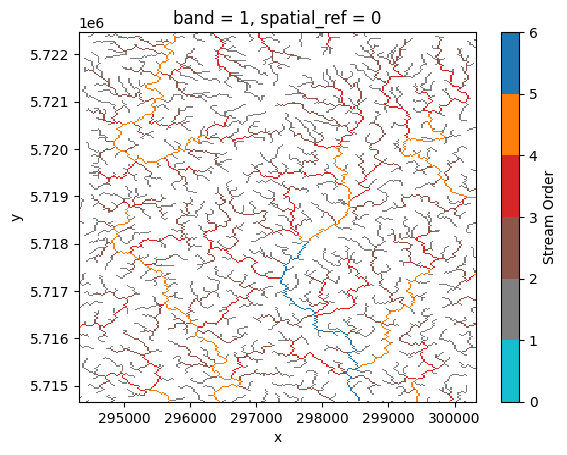

In [4]:
plot_dir = Path("images")
plot_dir.mkdir(parents=True, exist_ok=True)
stream_order = utils.tiff_to_da(save_dir / "strahler.tif", "uint8", long_name="Stream Order", nodata=0)
levels = range(stream_order.max().item() + 1)
ax = stream_order.where(stream_order > 0).plot.imshow(robust=False, levels=levels, cmap="tab10_r")
ax.figure.savefig(plot_dir / "stream_order.png", dpi=90)

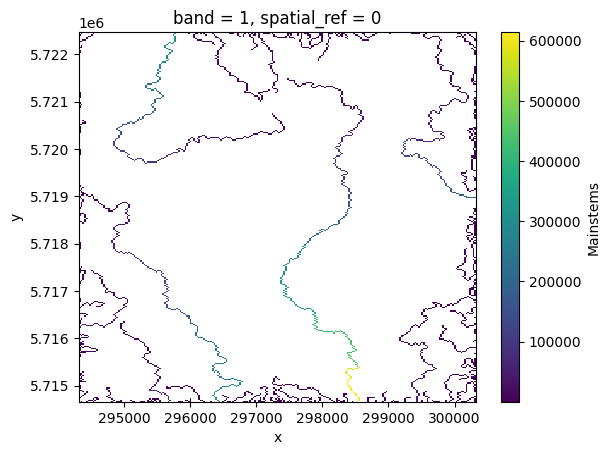

In [5]:
mainstem = utils.tiff_to_da(f"{save_dir}/mainstem.tif", long_name="Mainstems")
_ = mainstem.where(mainstem > 0).plot.imshow()

In [6]:
basin_geo = utils.tiff_to_gdf(f"{save_dir}/basins.tif", "int32", "basin")
basin_geo.loc[[basin_geo.area.idxmax()]].explore()